# PreProcess Data

==>> holton_mass_data_normalized shape: (309700, 75)
==>> holton_mass_input_all: (309699, 76)
==>> State A samples: (173112, 76)
==>> State B samples: (118756, 76)


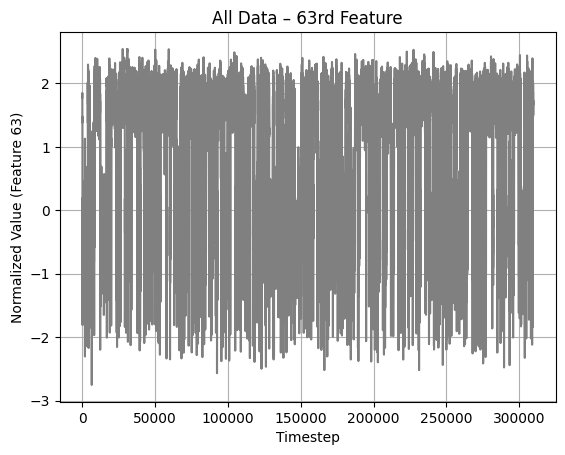

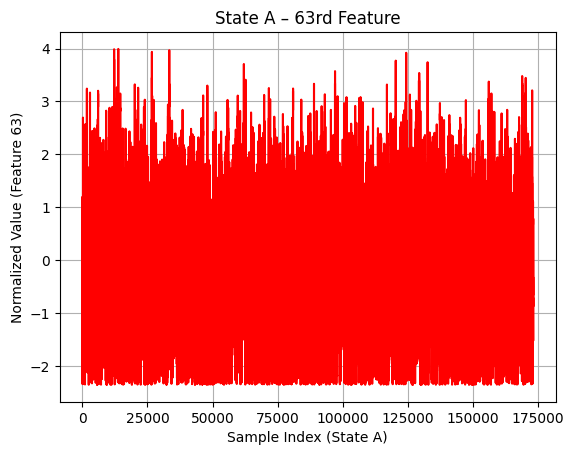

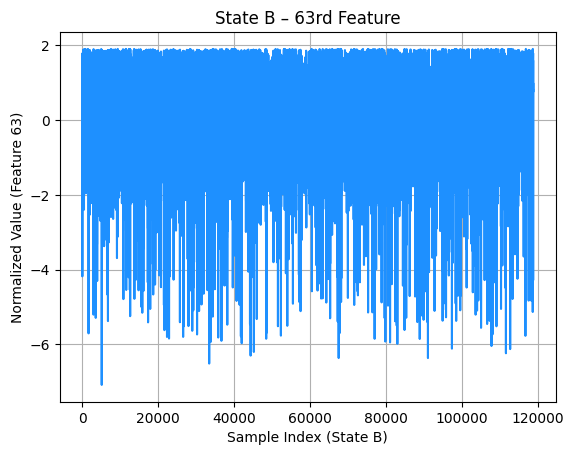

In [ ]:
import numpy as np
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from numpy import linalg

holton_mass_data = np.load(r"c:\users\danie\onedrive\desktop\work_torch\long_run_310k.npy")
holton_mass_data = holton_mass_data[:, 0, :]
# shape = (holton_mass_data.shape[0] *2, 75)

# holton_mass_data = np.reshape(holton_mass_data, shape)
holton_mass_data_normalized = (holton_mass_data - np.mean(holton_mass_data))  / np.std(holton_mass_data)
print(f"==>> holton_mass_data_normalized shape: {holton_mass_data_normalized.shape}")

lead = 1

# All Data in Both States and Transition Region
holton_mass_input_all =  holton_mass_data_normalized[0:holton_mass_data.shape[0] - lead, :]
holton_mass_label_all = holton_mass_data_normalized[lead:holton_mass_data.shape[0], :]

assert np.all(holton_mass_input_all[100_001, :] == holton_mass_label_all[100_000, :]), "Ensure the input and label data are properly offset by lead"

holton_mass_input_all = np.append(holton_mass_input_all, np.ones((holton_mass_input_all.shape[0], 1)), axis=1)
print(f"==>> holton_mass_input_all: {holton_mass_input_all.shape}")

upper_bound = 18.59 
lower_bound = 7.41

#Data in State A
state_A_indices = np.where(holton_mass_data[:-1, 63] > upper_bound)[0]
holton_mass_input_A = (holton_mass_data[state_A_indices] - holton_mass_data[state_A_indices].mean(0)) / holton_mass_data[state_A_indices].std(0)
holton_mass_input_A = np.append(holton_mass_input_A, np.ones((holton_mass_input_A.shape[0], 1)), axis=1)
holton_mass_label_A = holton_mass_data_normalized[state_A_indices+lead, :]
print(f"==>> State A samples: {holton_mass_input_A.shape}")

#Data in State B
state_B_indices = np.where(holton_mass_data[:-1, 63] < lower_bound)[0]
holton_mass_input_B = (holton_mass_data[state_B_indices] - holton_mass_data[state_B_indices].mean(0)) / holton_mass_data[state_B_indices].std(0)
holton_mass_input_B = np.append(holton_mass_input_B, np.ones((holton_mass_input_B.shape[0], 1)), axis=1)
holton_mass_label_B = holton_mass_data_normalized[state_B_indices+lead, :]
print(f"==>> State B samples: {holton_mass_input_B.shape}")

plt.figure()
plt.plot(holton_mass_data_normalized[:, 63], color='gray')
plt.title("All Data – 63rd Feature")
plt.xlabel("Timestep")
plt.ylabel("Normalized Value (Feature 63)")
plt.grid(True)

plt.figure()
plt.plot(holton_mass_input_A[:, 63], color='red')
plt.title("State A – 63rd Feature")
plt.xlabel("Sample Index (State A)")
plt.ylabel("Normalized Value (Feature 63)")
plt.grid(True)

plt.figure()
plt.plot(holton_mass_input_B[:, 63], color='dodgerblue')
plt.title("State B – 63rd Feature")
plt.xlabel("Sample Index (State B)")
plt.ylabel("Normalized Value (Feature 63)")
plt.grid(True)

plt.show()


# Find Linear Model Coeffecients

In [121]:
def linear_model_coeffs(X, Y):
    M_bias, resids, rank, singular_values = np.linalg.lstsq(X, Y)
    M = M_bias[:-1, :]
    c = M_bias[-1:, :].T
    residuals = Y - X @ M_bias
    BBT = residuals.T @ residuals / (residuals.shape[0] - 1)
    return M, c, BBT

# Determine Stationary Distribution

In [122]:
def stationary_distribution (M, c, BBT):
    mu = np.linalg.inv((np.eye(M.shape[0]) - M)) @ c
    gamma = scipy.linalg.solve_discrete_lyapunov(M, BBT)
    return mu, gamma

# Marginal Distributions

In [123]:

def plot_marginal_distributions(feature_indices, mu, gamma, normalized_data):
    num_features = len(feature_indices)
    n_cols = 3  
    n_rows = (num_features + n_cols - 1) // n_cols  

    x = np.linspace(-5, 5, 500)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()  

    for i, index in enumerate(feature_indices):
        mean = mu[index]
        std = np.sqrt(gamma[index, index])
        pdf = norm.pdf(x, mean, std)

        empirical_values = normalized_data[:, index]

        print(f"Feature {index} | mu: {mean.item():.2f}, std: {std.item():.2f}, max PDF height: {pdf.max():.4f}")
        ax = axes[i]
        ax.hist(empirical_values, bins=50, density=True, alpha=0.5, label='Holton Mass Empirical', color='dodgerblue')
        ax.plot(x, pdf, color='green', label='Linear Model Gaussian')
        ax.set_title(f"Feature {index}")
        ax.set_xlabel("Value")
        ax.grid(True)
        ax.legend()

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# 1st Linear Model, Evolve Under Data in State A and B

Max |eigvals(M)| = 0.26081008785614745
Feature 13 | mu: 40.66, std: 0.87, max PDF height: 0.0000
Feature 37 | mu: -42.72, std: 0.40, max PDF height: 0.0000
Feature 63 | mu: 138.22, std: 16.04, max PDF height: 0.0000


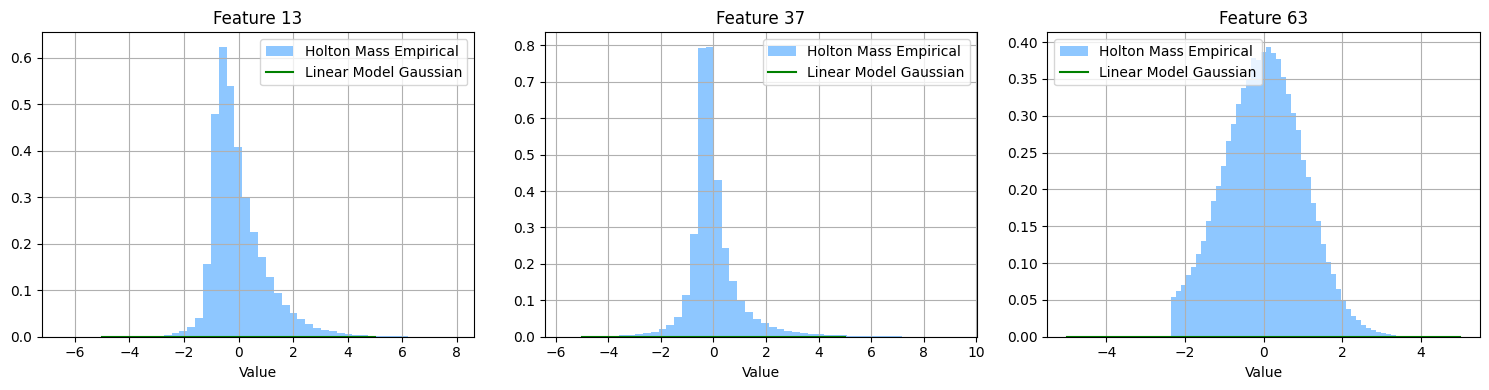

Max |eigvals(M)| = 0.8686758529620621
Feature 13 | mu: 0.92, std: 0.91, max PDF height: 0.4375
Feature 37 | mu: -2.39, std: 0.38, max PDF height: 1.0578
Feature 63 | mu: -18.48, std: 2.52, max PDF height: 0.0000


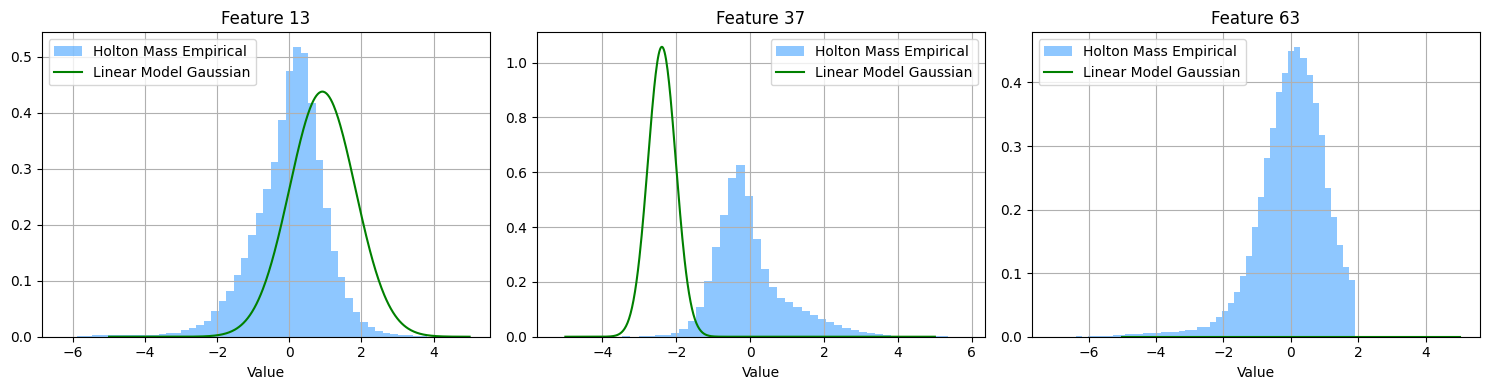

In [124]:
feature_indices = [13, 37, 63]
M, c, BBT = linear_model_coeffs(holton_mass_input_A, holton_mass_label_A)
eigvals = np.linalg.eigvals(M)
print("Max |eigvals(M)| =", np.max(np.abs(eigvals)))
mu, gamma = stationary_distribution(M, c, BBT)
plot_marginal_distributions(feature_indices, mu, gamma, holton_mass_input_A)

M, c, BBT = linear_model_coeffs(holton_mass_input_B, holton_mass_label_B)
eigvals = np.linalg.eigvals(M)
print("Max |eigvals(M)| =", np.max(np.abs(eigvals)))
mu, gamma = stationary_distribution(M, c, BBT)
plot_marginal_distributions(feature_indices, mu, gamma, holton_mass_input_B)

# 2nd Linear Model, Evolve Under Data in State A and B

Max |eigvals(M)| = 0.9950451219322841
Feature 13 | mu: -115399.55, std: 109.46, max PDF height: 0.0000
Feature 37 | mu: 291560.32, std: 135.23, max PDF height: 0.0000
Feature 63 | mu: -592239.74, std: 259.87, max PDF height: 0.0000


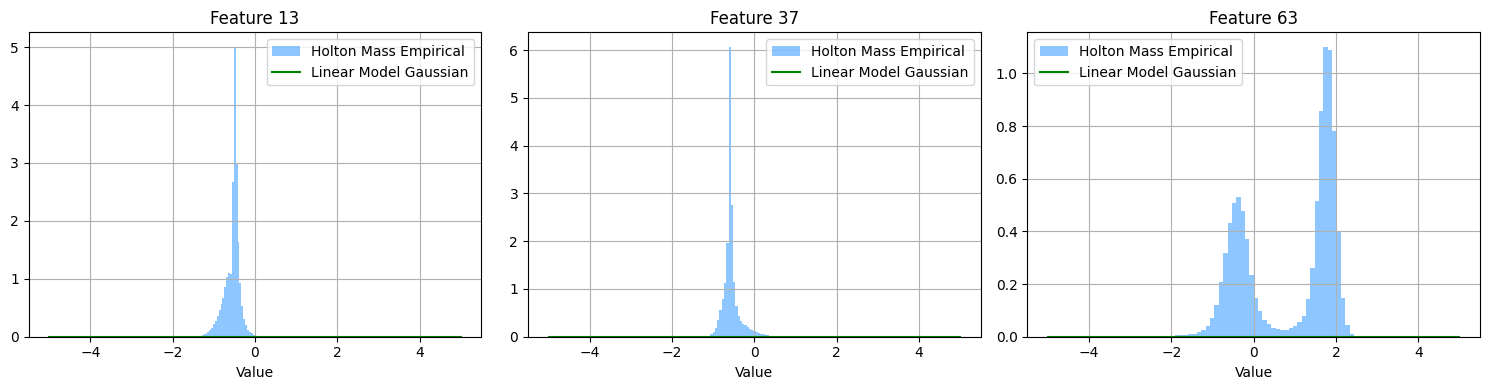

In [120]:
M, c, BBT = linear_model_coeffs(holton_mass_input_all, holton_mass_label_all)
eigvals = np.linalg.eigvals(M)
print("Max |eigvals(M)| =", np.max(np.abs(eigvals)))
mu, gamma = stationary_distribution(M, c, BBT)
plot_marginal_distributions(feature_indices, mu, gamma, holton_mass_input_all)

# EDMD

Original dimension: 75
Augmented dimension: 2850

=== State A Analysis ===
Max |eigvals(M)| = 2.12007889355777


C:\Users\danie\AppData\Local\Temp\ipykernel_19504\2268888889.py:111: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(gamma[index, index])


Feature 13 | mu: 519003.17, std: nan, max PDF height: nan
Feature 37 | mu: 638725.18, std: nan, max PDF height: nan
Feature 63 | mu: 5732722.91, std: 31239.27, max PDF height: 0.0000


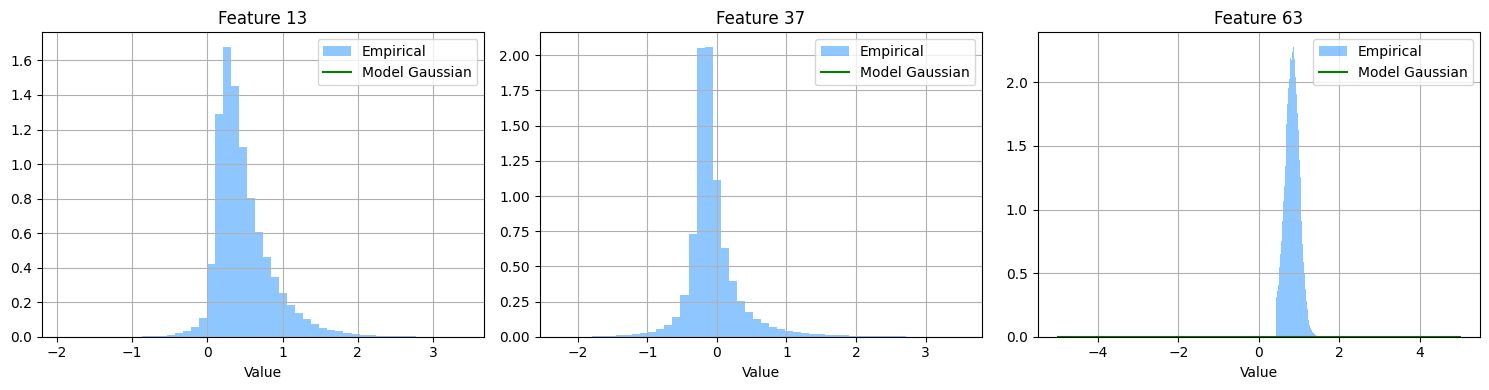


=== State B Analysis ===
Max |eigvals(M)| = 2.4107976318508215
Feature 13 | mu: 26.53, std: 16.51, max PDF height: 0.0103
Feature 37 | mu: -50.99, std: 16.68, max PDF height: 0.0005
Feature 63 | mu: -23.88, std: 1797.77, max PDF height: 0.0002


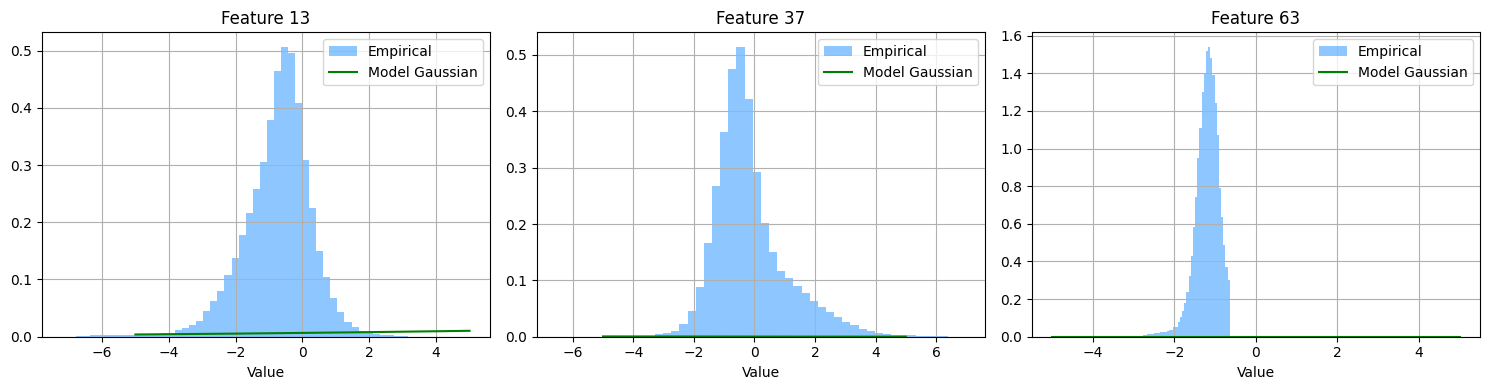


=== All Data Analysis ===
Max |eigvals(M)| = 2.008172797994472
Feature 13 | mu: -1.18, std: 1273.97, max PDF height: 0.0003
Feature 37 | mu: -19.72, std: 1295.08, max PDF height: 0.0003
Feature 63 | mu: 348.14, std: 2815.25, max PDF height: 0.0001


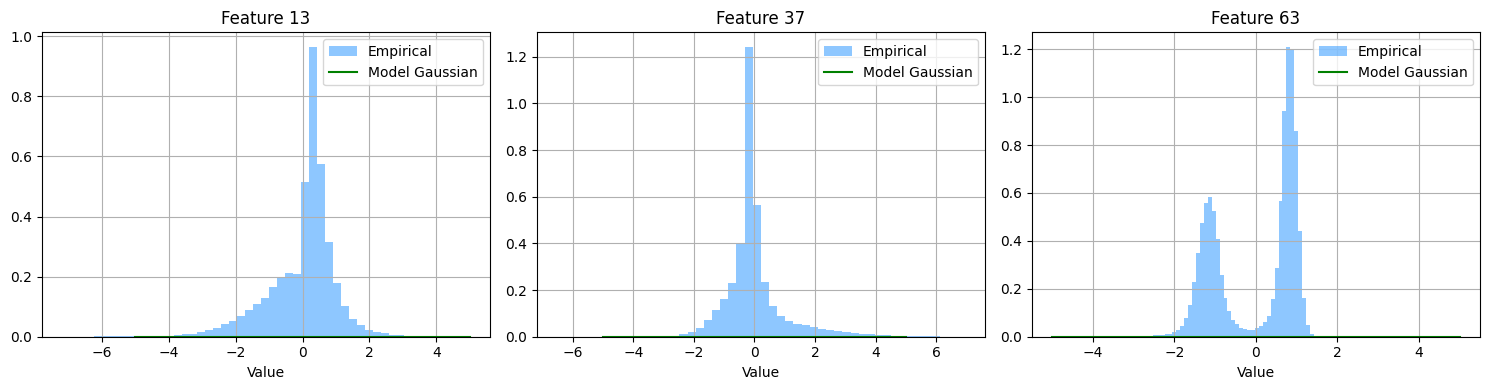

In [127]:
import numpy as np
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from numpy import linalg

def augment_with_quadratic(X):
    n_samples, n_features = X.shape
    n_quadratic = n_features * (n_features - 1) // 2
    X_aug = np.zeros((n_samples, n_features + n_quadratic))
    
    X_aug[:, :n_features] = X
    
    quad_index = n_features
    for i in range(n_features):
        for j in range(i, n_features):
            if i == j:
                continue 
            X_aug[:, quad_index] = X[:, i] * X[:, j]
            quad_index += 1
            
    return X_aug

holton_mass_data = np.load(r"c:\users\danie\onedrive\desktop\work_torch\long_run_310k.npy")
holton_mass_data = holton_mass_data[:, 0, :]

data_mean = np.mean(holton_mass_data, axis=0)
data_std = np.std(holton_mass_data, axis=0)
holton_mass_data_normalized = (holton_mass_data - data_mean) / data_std

#This will augment the data with quadratic features
holton_mass_data_augmented = augment_with_quadratic(holton_mass_data_normalized)
print(f"Original dimension: {holton_mass_data_normalized.shape[1]}")
print(f"Augmented dimension: {holton_mass_data_augmented.shape[1]}")

lead = 1
upper_bound = 18.59 
lower_bound = 7.41

def prepare_augmented_data(data_augmented, original_data, lead, bound, comparison_op):
    indices = np.where(comparison_op(original_data[:-1, 63], bound))[0]
    X = data_augmented[indices]
    Y = data_augmented[indices + lead]
    return X, Y, indices

X_A_aug, Y_A_aug, state_A_indices = prepare_augmented_data(
    holton_mass_data_augmented, holton_mass_data, lead, upper_bound, np.greater)

X_B_aug, Y_B_aug, state_B_indices = prepare_augmented_data(
    holton_mass_data_augmented, holton_mass_data, lead, lower_bound, np.less)

X_all_aug = holton_mass_data_augmented[:-lead]
Y_all_aug = holton_mass_data_augmented[lead:]

X_A_aug = np.append(X_A_aug, np.ones((X_A_aug.shape[0], 1)), axis=1)
X_B_aug = np.append(X_B_aug, np.ones((X_B_aug.shape[0], 1)), axis=1)
X_all_aug = np.append(X_all_aug, np.ones((X_all_aug.shape[0], 1)), axis=1)

def linear_model_coeffs(X, Y):
    M_bias, resids, rank, singular_values = np.linalg.lstsq(X, Y, rcond=None)
    M = M_bias[:-1, :]
    c = M_bias[-1:, :].T
    residuals = Y - X @ M_bias
    BBT = residuals.T @ residuals / (X.shape[0] - M_bias.shape[1])
    return M, c, BBT

def stationary_distribution(M, c, BBT):
    M_original = M[:75, :75] 
    c_original = c[:75] 
    BBT_original = BBT[:75, :75]
    
    try:
        mu = np.linalg.solve((np.eye(75) - M_original), c_original)
        gamma = scipy.linalg.solve_discrete_lyapunov(M_original, BBT_original)
        return mu, gamma
    except np.linalg.LinAlgError:
        print("Matrix singular, using pseudo-inverse")
        mu = np.linalg.pinv(np.eye(75) - M_original) @ c_original
        gamma = scipy.linalg.solve_discrete_lyapunov(M_original, BBT_original)
        return mu, gamma

def plot_marginal_distributions(feature_indices, mu, gamma, normalized_data):
    num_features = len(feature_indices)
    n_cols = 3  
    n_rows = (num_features + n_cols - 1) // n_cols  

    x = np.linspace(-5, 5, 500)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()  

    for i, index in enumerate(feature_indices):
        mean = mu[index]
        std = np.sqrt(gamma[index, index])
        pdf = norm.pdf(x, mean, std)

        empirical_values = normalized_data[:, index]

        print(f"Feature {index} | mu: {mean.item():.2f}, std: {std.item():.2f}, max PDF height: {pdf.max():.4f}")
        ax = axes[i]
        ax.hist(empirical_values, bins=50, density=True, alpha=0.5, label='Empirical', color='dodgerblue')
        ax.plot(x, pdf, color='green', label='Model Gaussian')
        ax.set_title(f"Feature {index}")
        ax.set_xlabel("Value")
        ax.grid(True)
        ax.legend()

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

feature_indices = [13, 37, 63]

print("\n=== State A Analysis ===")
M_A, c_A, BBT_A = linear_model_coeffs(X_A_aug, Y_A_aug)
eigvals = np.linalg.eigvals(M_A[:75, :75])  
print("Max |eigvals(M)| =", np.max(np.abs(eigvals)))
mu_A, gamma_A = stationary_distribution(M_A, c_A, BBT_A)
plot_marginal_distributions(feature_indices, mu_A, gamma_A, holton_mass_data_normalized[state_A_indices])

print("\n=== State B Analysis ===")
M_B, c_B, BBT_B = linear_model_coeffs(X_B_aug, Y_B_aug)
eigvals = np.linalg.eigvals(M_B[:75, :75])  
print("Max |eigvals(M)| =", np.max(np.abs(eigvals)))
mu_B, gamma_B = stationary_distribution(M_B, c_B, BBT_B)
plot_marginal_distributions(feature_indices, mu_B, gamma_B, holton_mass_data_normalized[state_B_indices])

print("\n=== All Data Analysis ===")
M_all, c_all, BBT_all = linear_model_coeffs(X_all_aug, Y_all_aug)
eigvals = np.linalg.eigvals(M_all[:75, :75])
print("Max |eigvals(M)| =", np.max(np.abs(eigvals)))
mu_all, gamma_all = stationary_distribution(M_all, c_all, BBT_all)
plot_marginal_distributions(feature_indices, mu_all, gamma_all, holton_mass_data_normalized[:-lead])